https://github.com/thu-ml/zhusuan/blob/master/examples/bayesian_neural_nets/bayesian_nn.py

In [1]:
import numpy as np
import edward as ed
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from edward.models import Normal, Empirical

ed.set_seed(12)
sns.set()
%matplotlib inline

In [101]:
# Our model will be a two-layer neural network.
def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.matmul(x, W_0) + b_0
    h = tf.tanh(h)
    #h = tf.exp(tf.negative(tf.square(h)))
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

def display_draws(x_data, y_data, draw_inputs, draw_outputs, label):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(x_data, y_data, 'ks', alpha=0.5, label='(x, y)')
    ax.plot(draw_inputs, draw_outputs[0].T, 'r', lw=2, alpha=0.5, label=label)
    ax.plot(draw_inputs, draw_outputs[1:].T, 'r', lw=2, alpha=0.5)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-2, 3])
    ax.legend()
    plt.show()

In [173]:
num_points = 10000
N = 3*num_points

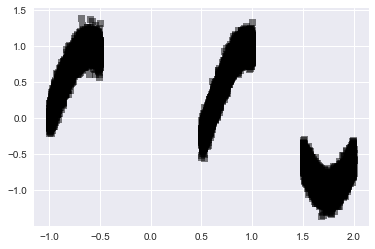

In [174]:
x_train = np.concatenate([np.linspace(0, 2, num=num_points),
                           np.linspace(6, 8, num=num_points),np.linspace(10, 12, num=num_points)])
y_train = np.sin(x_train) + np.random.normal(0, 0.1, size=N)
x_train = (x_train - 4.0) / 4.0
x_train = x_train.reshape((N,1))


plt.plot(x_train, y_train, 'ks', alpha=0.5)

In [175]:
# Build a Bayesian Neural Network with normal priors over weights
W_0 = Normal(loc=tf.zeros([1, 20]), scale=tf.ones([1, 20]))
W_1 = Normal(loc=tf.zeros([20, 1]), scale=tf.ones([20, 1]))
b_0 = Normal(loc=tf.zeros(20), scale=tf.ones(20))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = tf.placeholder(tf.float32, (N,1))
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1), scale=0.1*tf.ones(N))

In [176]:
# Posterior approximators
qW_0 = Normal(loc=tf.Variable(tf.random_normal([1, 20])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1, 20]))))
qW_1 = Normal(loc=tf.Variable(tf.random_normal([20, 1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([20, 1]))))
qb_0 = Normal(loc=tf.Variable(tf.random_normal([20])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([20]))))
qb_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [177]:
# Sample neural networks from our variational model.
rs = np.random.RandomState(0)
inputs = np.linspace(-5, 5, num=500, dtype=np.float32)
nx = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [neural_network(nx, qW_0.sample(), qW_1.sample(), qb_0.sample(), qb_1.sample())
     for _ in range(4)])

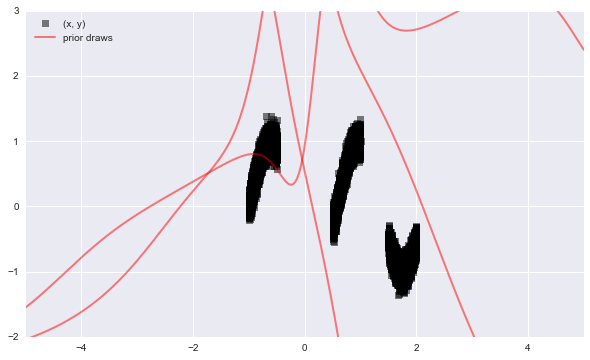

In [178]:
# Visualize prior draws.
sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()
display_draws(x_train, y_train, inputs, outputs, 'prior draws')

In [179]:
%run elbo_optimizer.py

In [180]:
batch=N/10

In [162]:
# Build a Bayesian Neural Network with normal priors over weights
W_0 = Normal(loc=tf.zeros([1, 20]), scale=tf.ones([1, 20]))
W_1 = Normal(loc=tf.zeros([20, 1]), scale=tf.ones([20, 1]))
b_0 = Normal(loc=tf.zeros(20), scale=tf.ones(20))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = tf.placeholder(tf.float32, (batch,1))
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1), scale=0.1*tf.ones(batch))
# Posterior approximators
qW_0 = Normal(loc=tf.Variable(tf.random_normal([1, 20])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1, 20]))))
qW_1 = Normal(loc=tf.Variable(tf.random_normal([20, 1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([20, 1]))))
qb_0 = Normal(loc=tf.Variable(tf.random_normal([20])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([20]))))
qb_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
y_pre = Normal(loc=neural_network(x, qW_0,qW_1, qb_0, qb_1), scale=0.1*tf.ones(batch))

x_batch = x_train[0:batch,]
y_batch = y_train[0:batch,]

In [163]:
# Training: Minimize the KL-divergence of our posterior approximators.
inference = test({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1},
                    data={x: x_batch, y: y_batch})

In [164]:
inference.initialize(var_list=tf.trainable_variables())

In [165]:
sess = ed.get_session()
tf.global_variables_initializer().run()

In [166]:
x_ph = tf.placeholder(tf.float32, (batch,1))
y_ph = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1), scale=0.1*tf.ones(batch))
n_epoch = 2000
train_loss = np.zeros(n_epoch)

In [167]:
perm = np.random.permutation(N)

In [168]:
i=0

In [169]:
info_dict = inference.update(feed_dict={x_ph: x_train[perm[i:i+batch]], y_ph: y_train[perm[i:i+batch]]})

In [170]:
info_dict

{'loss': 17746.871, 't': 1}

In [171]:
tt = tf.gradients(xs=[W_0, W_1, b_0, b_1], ys=build[0])

In [172]:
tt

[None, None, None, None]

In [54]:
build =inference.build_loss_and_gradients(var_list=tf.trainable_variables())

In [58]:
build = build_reparam_kl_loss_and_gradients(inference, var_list=tf.trainable_variables())

In [96]:
build[0]

<tf.Tensor 'Neg_9:0' shape=() dtype=float32>

# KLqp optimizer

In [181]:
# Training: Minimize the KL-divergence of our posterior approximators.
inference = test({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1},
                    data={x: x_train, y: y_train})
inference.initialize(var_list=tf.trainable_variables())
sess = ed.get_session()
tf.global_variables_initializer().run()

In [182]:
x_ph = tf.placeholder(tf.float32, (N,1))
y_ph = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1), scale=0.1*tf.ones(N))
n_epoch = 2000
train_loss = np.zeros(n_epoch)

In [183]:
for i in range(n_epoch):
    data = np.random.randint(1,len(x_train),1)[0]
    info_dict = inference.update(feed_dict={x_ph: x_train, y_ph: y_train})
    train_loss[i] = info_dict['loss']
    if i%100==0:
        inference.print_progress(info_dict)

   1/1000 [  0%]                                ETA: 4146s | Loss: 69971848.000

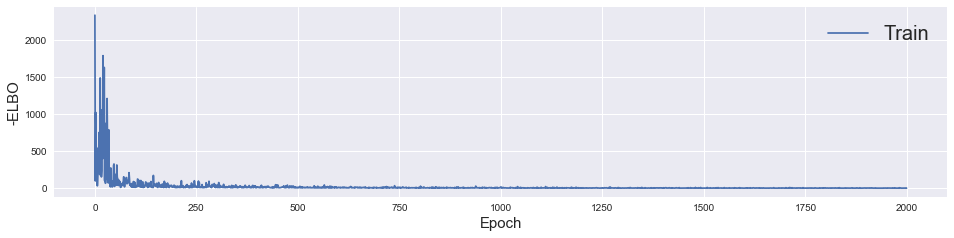

In [184]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(n_epoch), train_loss / len(x_train), label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('-ELBO', fontsize=15)
plt.show()

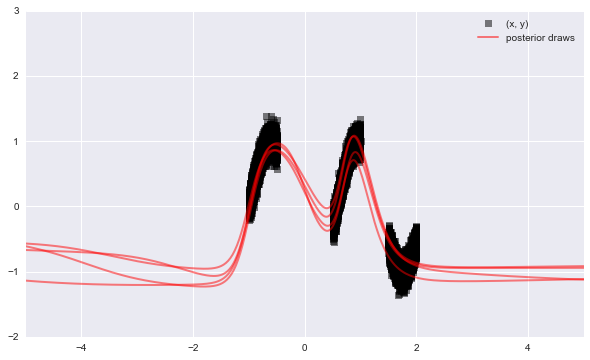

In [185]:
# Visualize posterior draws.
outputs = mus.eval()
display_draws(x_train, y_train, inputs, outputs, 'posterior draws')